##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Dogs vs Cats Image Classification Without Image Augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

このチュートリアルでは、画像を猫の写真または犬の写真に分類する方法について説明します。 `tf.keras.Sequential`モデルを使用して画像分類子を構築し、` tf.keras.preprocessing.image.ImageDataGenerator`を使用してデータをロードします。

## Specific concepts that will be covered:

その過程で、以下の概念に関する実践的な経験を構築し、直感を開発します。

* `tf.keras.preprocessing.image.ImageDataGenerator`クラスを使用して_データ入力パイプラインを構築—ディスク上のデータを効率的に操作してモデルとインターフェイスする方法
* _オーバーフィット_-それは何ですか、それを識別する方法は？

**Before you begin**

このノートブックでコードを実行する前に、上記のメニューで**Runtime-> Reset all runtimes**に移動してランタイムをリセットします。 複数のノートブックを使用している場合、これはColabのメモリ制限に到達することを回避するのに役立ちます。


# Importing packages

必要なパッケージをインポートすることから始めましょう：

* os —ファイルとディレクトリ構造を読み取る
* numpy — TensorFlow以外の一部の行列演算用
* matplotlib.pyplot —グラフをプロットし、トレーニングおよび検証データに画像を表示します

In [ ]:
#from __future__ import absolute_import, division, print_function, unicode_literals

In [1]:
# try:
#   # Use the %tensorflow_version magic if in colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

画像分類子を作成するには、まずデータセットをダウンロードします。 使用しているデータセットは、<a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">犬と猫</a>のデータセットのフィルタリングされたバージョンです Kaggleから（最終的に、このデータセットはMicrosoft Researchによって提供されます）。

以前のColabsでは、<a href="https://www.tensorflow.org/datasets" target="_blank"> TensorFlow Datasets </a>を使用しました。これは、データセットを使用する非常に簡単で便利な方法です。 ただし、このColabでは、ディスクからデータを読み取るクラス `tf.keras.preprocessing.image.ImageDataGenerator`を使用します。 したがって、URLから*Dogs vs. Cats*を直接ダウンロードし、Colabファイルシステムに解凍する必要があります。

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

ダウンロードしたデータセットのディレクトリ構造は次のとおりです。

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

次の端末コマンドでディレクトリを一覧表示できます。

In [6]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/Users/hironsuz/.keras/datasets
/Users/hironsuz/.keras/datasets/cats_and_dogs_filtered
/Users/hironsuz/.keras/datasets/cats_and_dogs_filtered/train
/Users/hironsuz/.keras/datasets/cats_and_dogs_filtered/train/dogs
/Users/hironsuz/.keras/datasets/cats_and_dogs_filtered/train/cats
/Users/hironsuz/.keras/datasets/cats_and_dogs_filtered/validation
/Users/hironsuz/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/Users/hironsuz/.keras/datasets/cats_and_dogs_filtered/validation/cats
/Users/hironsuz/.keras/datasets/fashion-mnist


ここで、トレーニングセットと検証セットの適切なファイルパスを変数に割り当てます。

In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

トレーニングと検証のディレクトリにある猫と犬の画像の数を見てみましょう

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

便宜上、データセットの前処理とネットワークのトレーニング中に後で使用される変数を設定します。

In [10]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation 

画像を適切に前処理された浮動小数点テンソルにフォーマットしてから、ネットワークに入力する必要があります。 これらのイメージを準備する手順は次のとおりです。

1. ディスクから画像を読み取る
2. これらの画像のコンテンツをデコードし、RGBコンテンツに従って適切なグリッド形式に変換します
3. それらを浮動小数点テンソルに変換します
4. ニューラルネットワークは小さい入力値を処理することを好むため、テンソルを0〜255の値から0〜1の値に再スケーリングします。

幸いなことに、これらすべてのタスクはクラス**tf.keras.preprocessing.image.ImageDataGenerator**を使用して実行できます。

これを数行のコードで設定できます。

In [11]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

トレーニングおよび検証イメージ用のジェネレーターを定義した後、**flow_from_directory**メソッドは、ディスクからイメージをロードし、再スケーリングを適用し、1行のコードを使用してそれらのサイズを変更します。

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualizing Training images

トレーニングジェネレーターから画像のバッチを取得し、 `matplotlib`を使用してそれらのいくつかをプロットすることにより、トレーニング画像を視覚化できます。

In [14]:
sample_training_images, _ = next(train_data_gen) 

`next`関数はデータセットからバッチを返します。 1つのバッチは、（*多くの画像*、*多くのラベル*）のタプルです。 今のところ、画像を見たいだけなので、ラベルを破棄しています。

In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

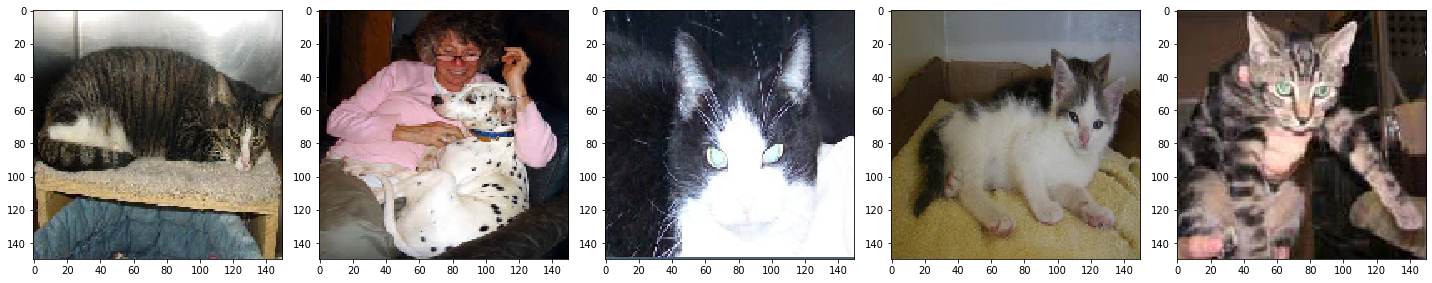

In [16]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

## Define the model
モデルは4つの畳み込みブロックで構成され、それぞれに最大プール層があります。 次に、 `relu`アクティベーション機能を備えた、512ユニットの完全に接続されたレイヤーがあります。 モデルは、 `softmax`を使用して、犬と猫の2つのクラスのクラス確率を出力します。

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

### Compile the model
いつものように、 `adam`オプティマイザーを使用します。 softmax分類を出力するため、損失関数として `sparse_categorical_crossentropy`を使用します。 また、ネットワークをトレーニングする際に、各エポックでのトレーニングと検証の精度を確認したいので、メトリックス引数を渡します。

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

**summary**メソッドを使用して、ネットワークのすべてのレイヤーを見てみましょう。

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Train the model

ネットワークをトレーニングするときです。

バッチはジェネレーター（ `ImageDataGenerator`）から送信されるため、` fit`の代わりに `fit_generator`を使用します。

In [20]:
#EPOCHS = 100
EPOCHS = 5
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/5
20/20 [==============================] - 54s 3s/step - loss: 0.7513 - accuracy: 0.4975 - val_loss: 0.6928 - val_accuracy: 0.5070
Epoch 2/5
20/20 [==============================] - 53s 3s/step - loss: 0.6897 - accuracy: 0.5460 - val_loss: 0.6775 - val_accuracy: 0.6290
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.6692 - accuracy: 0.5900 - val_loss: 0.6569 - val_accuracy: 0.6400
Epoch 4/5
20/20 [==============================] - 53s 3s/step - loss: 0.6327 - accuracy: 0.6500 - val_loss: 0.7121 - val_accuracy: 0.5200
Epoch 5/5
20/20 [==============================] - 53s 3s/step - loss: 0.6036 - accuracy: 0.6640 - val_loss: 0.6069 - val_accuracy: 0.6850


### Visualizing results of the training

ネットワークをトレーニングした後に得られる結果を視覚化します。

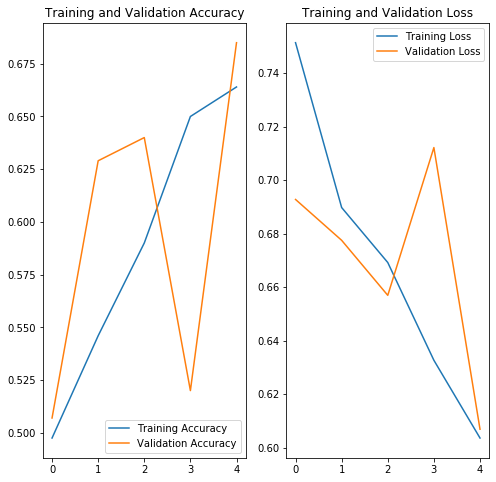

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

プロットからわかるように、トレーニングの精度と検証の精度は大幅に外れており、モデルは検証セットで**70％**の精度しか達成していません（トレーニングしたエポックの数によって異なります）。

これは、過剰適合の明確な兆候です。 トレーニングと検証曲線が発散し始めると、モデルはトレーニングデータを記憶し始め、検証データでうまく機能できなくなります。